In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git


In [ ]:
pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-8x74thxq
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-8x74thxq
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=273ebe7f4090e01afc3a8ea9801e6576f4a2f8b5610f06bd2f9c1348cc7ab170
  Stored in directory: /tmp/pip-ephem-wheel-cache-v1qobn96/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
import tensorflow as tf
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE


In [ ]:
dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite',
                              with_info=True, as_supervised=True)

train_summers, train_winters = dataset['trainA'], dataset['trainB']
test_summers, test_winters = dataset['testA'], dataset['testB']


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteHT15LO/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteHT15LO/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteHT15LO/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteHT15LO/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256


In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image


In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image


In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image


In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image


In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image


In [ ]:
train_summers = train_summers.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_winters = train_winters.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_summers = test_summers.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_winters = test_winters.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [ ]:
sample_summer = next(iter(train_summers))
sample_winter = next(iter(train_winters))


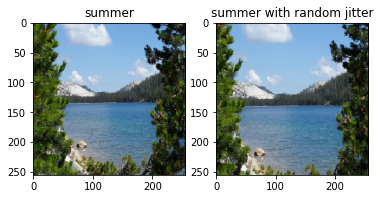

In [ ]:
plt.subplot(121)
plt.title('summer')
plt.imshow(sample_summer[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('summer with random jitter')
plt.imshow(random_jitter(sample_summer[0]) * 0.5 + 0.5)


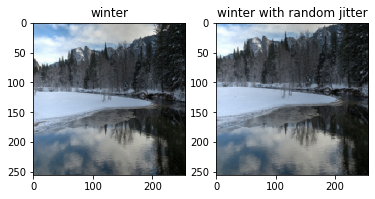

In [ ]:
plt.subplot(121)
plt.title('winter')
plt.imshow(sample_winter[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('winter with random jitter')
plt.imshow(random_jitter(sample_winter[0]) * 0.5 + 0.5)


**RESNET GENERATOR AND DISCRIMINATOR**

In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = tf.random_normal_initializer(0., 0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
def define_generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  n_resnet=6
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # c7s1-64
  g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(inputs)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
	# d128
  g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
	# d256
  g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
	# R256
  for _ in range(n_resnet):
    g = resnet_block(256, g)
	# u128
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
	# u64
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
	# c7s1-3
  g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  out_image = Activation('tanh')(g)
  return tf.keras.Model(inputs=inputs, outputs=out_image)


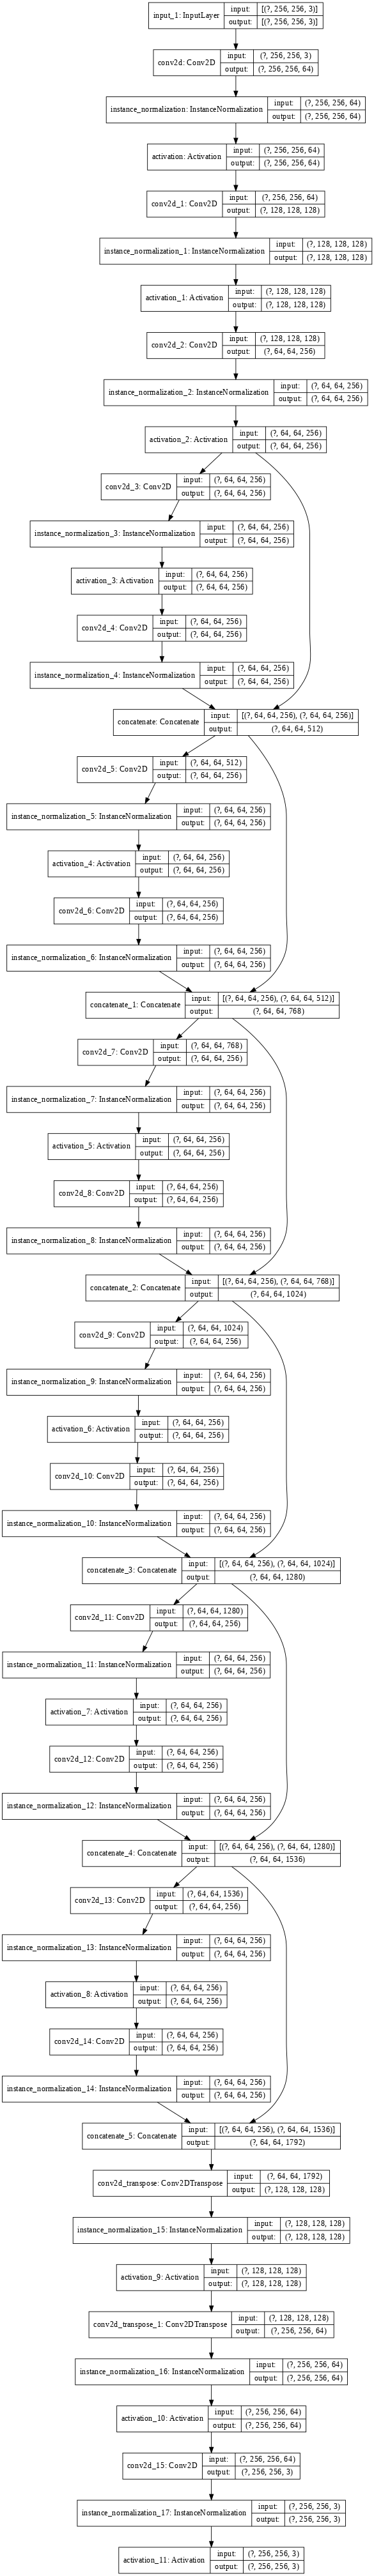

In [ ]:
generator = define_generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


In [ ]:
# define the discriminator model
def define_discriminator():
  init = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

	# C64
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inp)
  d = LeakyReLU(alpha=0.2)(d)
	# C128
  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
	# C256
  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.ZeroPadding2D()(d)
	# C512
  d = Conv2D(512, (4,4), strides=(1,1), kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.ZeroPadding2D()(d)

	# patch output
  last = Conv2D(1, (4,4), kernel_initializer=init)(d)
  return tf.keras.Model(inputs=inp, outputs=last)


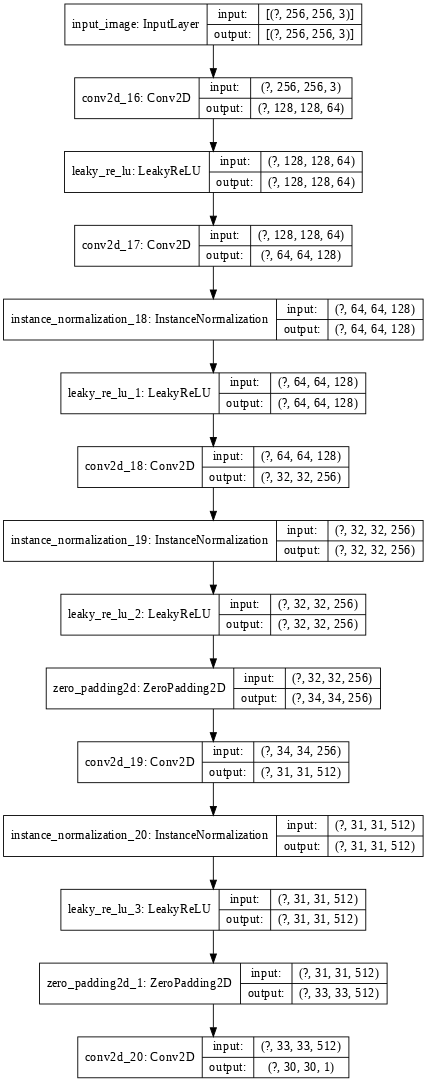

In [ ]:
discriminator = define_discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)


In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
generator_g = define_generator()
generator_f = define_generator()

discriminator_x = define_discriminator()
discriminator_y = define_discriminator()


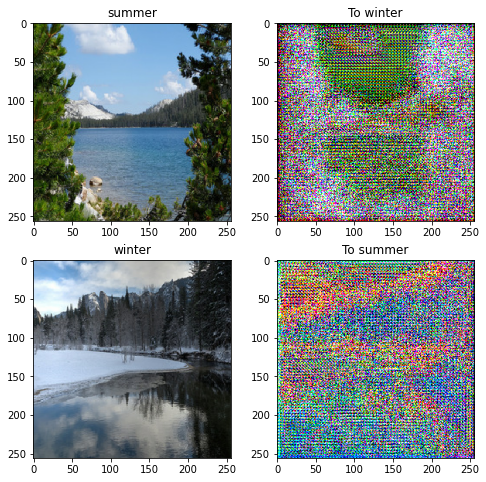

In [ ]:
to_winter = generator_g(sample_summer)
to_summer = generator_f(sample_winter)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ['summer', 'To winter', 'winter', 'To summer']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()


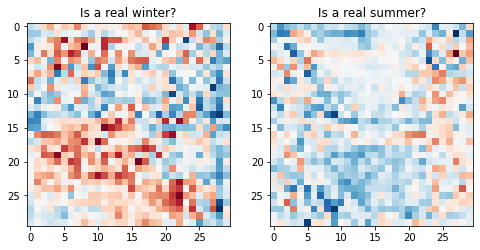

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real winter?')
plt.imshow(discriminator_y(sample_winter)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real summer?')
plt.imshow(discriminator_x(sample_summer)[0, ..., -1], cmap='RdBu_r')

plt.show()


**LOSS FUNCTIONS**

In [ ]:
LAMBDA = 10


In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1


In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss


In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)


**Checkpoints**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
checkpoint_path = "/content/drive/MyDrive/Project/resnet3"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


**Training**

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


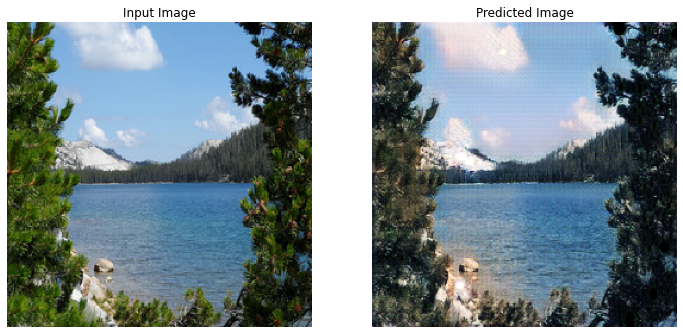

Saving checkpoint for epoch 40 at /content/drive/MyDrive/Project/resnet3/ckpt-8
Time taken for epoch 40 is 453.273802280426 sec



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_summers, train_winters)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_summer) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_summer)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))


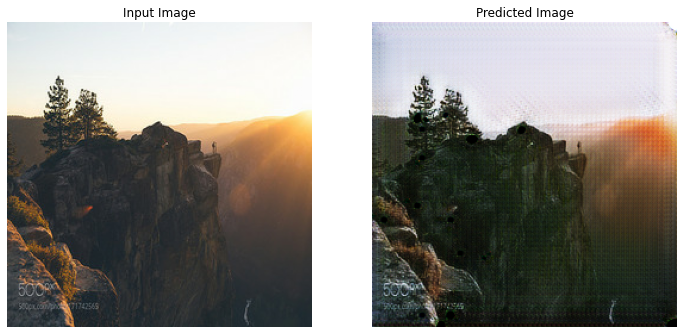

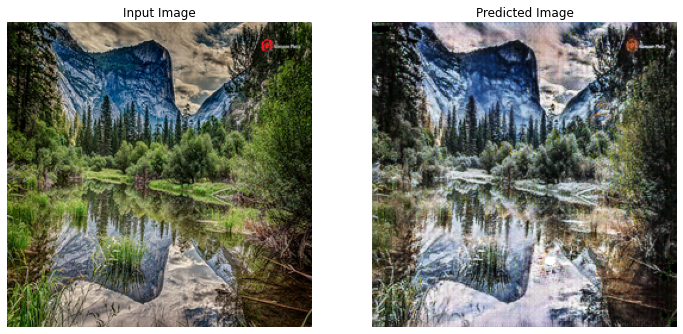

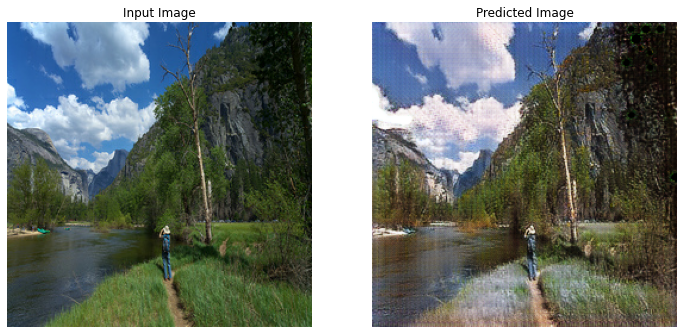

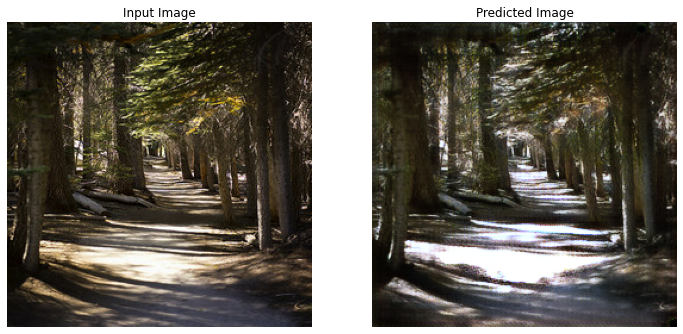

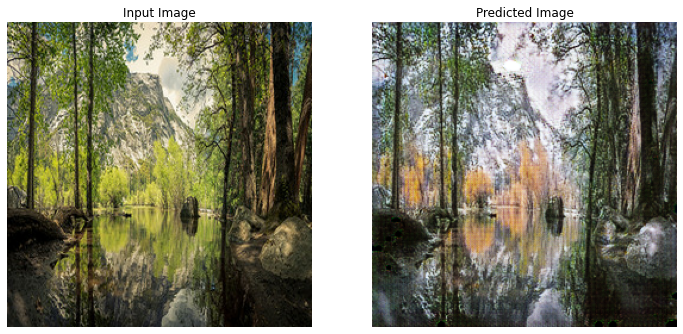

In [ ]:
# Run the trained model on the test dataset
for inp in test_summers.take(5):
  generate_images(generator_g, inp)


## **Test model from outside the dataset**

In [104]:
def load_img(summer_path):
  img = tf.io.read_file(summer_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)

  img = img[tf.newaxis, :]
  img = tf.image.resize(img, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return img



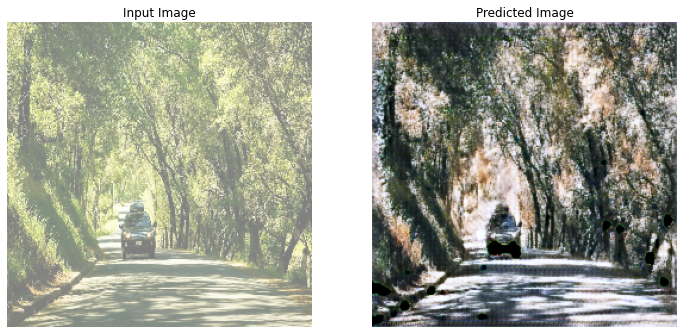

In [105]:
summer_url = "https://s.hdnux.com/photos/01/12/22/06/19472818/7/940x0.jpg"
summer_path = tf.keras.utils.get_file('940x0.jpg', origin=summer_url)
img=load_img(summer_path)
generate_images(generator_g, img)

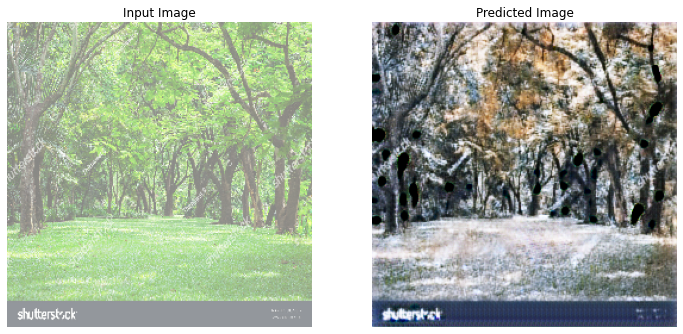

In [106]:
summer_url = "https://image.shutterstock.com/z/stock-photo-many-trees-which-green-fresh-leaves-and-green-grass-on-the-ground-in-the-park-outdoor-green-nature-708072877.jpg"
summer_path = tf.keras.utils.get_file('stock-photo-many-trees-which-green-fresh-leaves-and-green-grass-on-the-ground-in-the-park-outdoor-green-nature-708072877.jpg', origin=summer_url)
img=load_img(summer_path)
generate_images(generator_g, img)